# Jigsaw - Agile Community Rules Classification
*Using AI models to help moderators uphold community-specific norms.*

This competition challenges participants to create a **binary classifier** that predicts whether a Reddit comment breaks a specific rule. The goal is to develop a model that can identify **rule violations** within a large, unlabeled dataset of real-world comments. This task involves working with a diverse range of subreddits, each with its own unique set of community norms. The competition provides a practical opportunity to use machine learning to assist in **content moderation**, helping to bring some order to the complex and often chaotic world of online community guidelines.

### Workflow Steps:
1. Imports and Setup
2. Basic Data Exploration
3. Text cleaning & Feature Creation
4. Prepare text for vectorization
5. Data Preparation for Numerical Features
6. Model training 
   - 6.1 Logistic Regression (Baseline Model)
   - 6.2 XGBoost
   - 6.3 Random Forest
7. Hyperparameter optimization
8. Predictions

# 1. Imports and Setup

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import re
import string

In [19]:
# Load the data
print("Loading data...")
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submission.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Loading data...
Train shape: (2029, 9)
Test shape: (10, 8)


# 2. Basic EDA

In [20]:
print("\nTarget distribution:")
target_dist = train['rule_violation'].value_counts()
print(target_dist)
print("="*50)
print("\nRules in training:")
print(train['rule'].value_counts())


Target distribution:
rule_violation
1    1031
0     998
Name: count, dtype: int64

Rules in training:
rule
No legal advice: Do not offer or request legal advice.                                                     1017
No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.    1012
Name: count, dtype: int64


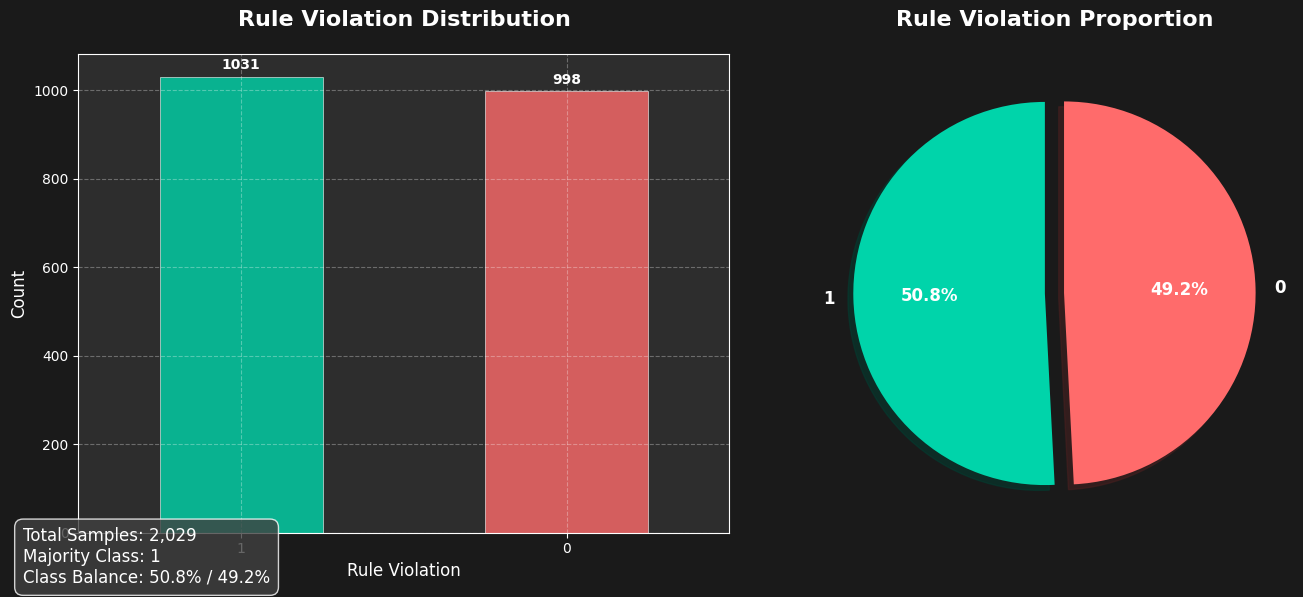

In [21]:
plt.style.use('dark_background')
sns.set_palette("viridis")


# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.patch.set_facecolor('#1a1a1a')

# Color palette for consistency
colors = ['#00d4aa', '#ff6b6b']

# Plot 1: Count Plot
target_dist.plot(kind='bar', ax=ax1, color=colors, alpha=0.8, edgecolor='white', linewidth=0.5)
ax1.set_title('Rule Violation Distribution', fontsize=16, fontweight='bold', color='white', pad=20)
ax1.set_xlabel('Rule Violation', fontsize=12, color='white')
ax1.set_ylabel('Count', fontsize=12, color='white')
ax1.tick_params(colors='white', rotation=0)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_facecolor('#2d2d2d')

# Add value labels on bars
for i, v in enumerate(target_dist.values):
    ax1.text(i, v + max(target_dist.values) * 0.01, str(v), 
            ha='center', va='bottom', color='white', fontweight='bold')

# Plot 2: Pie Chart
wedges, texts, autotexts = ax2.pie(target_dist.values, 
                                    labels=target_dist.index,
                                    colors=colors,
                                    autopct='%1.1f%%',
                                    startangle=90,
                                    explode=(0.05, 0.05),
                                    shadow=True)

# Customize pie chart text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

for text in texts:
    text.set_color('white')
    text.set_fontsize(12)
    text.set_fontweight('bold')

ax2.set_title('Rule Violation Proportion', fontsize=16, fontweight='bold', color='white', pad=20)

# Add summary statistics box
total_samples = target_dist.sum()
majority_class = target_dist.index[0]
majority_pct = (target_dist.iloc[0] / total_samples) * 100

stats_text = f'Total Samples: {total_samples:,}\nMajority Class: {majority_class}\nClass Balance: {majority_pct:.1f}% / {100-majority_pct:.1f}%'
fig.text(0.02, 0.02, stats_text, fontsize=12, color='white', 
        bbox=dict(boxstyle="round,pad=0.5", facecolor='#404040', alpha=0.8))

plt.tight_layout()
plt.show()

# 3. Text cleaning & Feature Creation

In [22]:
def clean_text(text):
    """Clean and preprocess text"""
    
    text = str(text).lower()
    # Remove special characters but keep spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # Remove extra whitespaces
    text = ' '.join(text.split())
    return text

In [23]:
def create_features(df):
    """Build clean and combined features for training/testing."""
    # Clean core text columns
    df['body_clean'] = df['body'].apply(clean_text)
    df['rule_clean'] = df['rule'].apply(clean_text)
    df['subreddit_clean'] = df['subreddit'].apply(clean_text)

    # Clean example columns (if present, else empty)
    for col in ['positive_example_1', 'positive_example_2', 
                'negative_example_1', 'negative_example_2']:
        if col in df.columns:
            df[f'{col}_clean'] = df[col].fillna('').apply(clean_text)
        else:
            df[f'{col}_clean'] = ''

    # Combine positive & negative examples
    df['positive_examples'] = df['positive_example_1_clean'] + ' ' + df['positive_example_2_clean']
    df['negative_examples'] = df['negative_example_1_clean'] + ' ' + df['negative_example_2_clean']

    # Main text features (like "entailment" input)
    df['comment_rule'] = df['body_clean'] + ' [SEP] ' + df['rule_clean']
    df['full_context'] = (
        df['body_clean'] + ' [SEP] ' + df['rule_clean'] +
        ' [SEP] ' + df['subreddit_clean'] +
        ' [SEP] positive: ' + df['positive_examples'] +
        ' [SEP] negative: ' + df['negative_examples']
    )

    # Simple numeric features
    df['body_len'] = df['body_clean'].str.len()
    df['rule_len'] = df['rule_clean'].str.len()
    df['body_words'] = df['body_clean'].str.split().str.len()

    return df

print("\nCreating features...")
train_processed = create_features(train.copy())
test_processed = create_features(test.copy())


Creating features...


# 4. Prepare text for vectorization

In [24]:
train_text = train_processed['full_context'].fillna('')
test_text = test_processed['full_context'].fillna('')

print("\nVectorizing text...")
vectorizer = TfidfVectorizer(
    max_features=20_000,  
    ngram_range=(1, 2),  
    min_df=2,            
    max_df=0.95,         
    stop_words='english'
)

X_text = vectorizer.fit_transform(train_text)
X_test_text = vectorizer.transform(test_text)


Vectorizing text...


# 5. Data Preparation for Numerical Features

In [25]:
numerical_features = ['body_len', 'rule_len', 'body_words']
X_num = train_processed[numerical_features].fillna(0)
X_test_num = test_processed[numerical_features].fillna(0)

scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Convert dense numerical features to sparse format  
X_num_sparse = csr_matrix(X_num_scaled)
X_test_num_sparse = csr_matrix(X_test_num_scaled)

# Stack sparse (TF-IDF) + dense (numerical) safely
X_combined = hstack([X_text, X_num_scaled])
X_test_combined = hstack([X_test_text, X_test_num_scaled])

In [26]:
y = train_processed['rule_violation']

print(f"\nFinal feature matrix shape: {X_combined.shape}")


Final feature matrix shape: (2029, 19906)


# 6. Model training 

### 6.1 Logistic Regression (Baseline Model)

In [27]:
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    class_weight='balanced',  
    random_state=42
)

# Cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(lr_model, X_combined, y, cv=cv, scoring='roc_auc')

print(f"CV AUC scores: {cv_scores}")
print(f"Mean CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Fit on full data
lr_model.fit(X_combined, y)


Training Logistic Regression...
CV AUC scores: [0.75941748 0.69349515 0.63135922 0.6384466  0.64330097 0.63019417
 0.65669903 0.67116505 0.62160062 0.6076297 ]
Mean CV AUC: 0.6553 (+/- 0.0839)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### 6.2 XGBoost

In [28]:
print("\nTraining XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    use_label_encoder=False, eval_metric='logloss')


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X_combined, y, cv=cv, scoring='roc_auc')


print(f"CV AUC scores: {cv_scores}")
print(f"Mean CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Training XGBoost...


c:\Users\perso\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:56:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\perso\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:56:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\perso\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:56:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\perso\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:56:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update

CV AUC scores: [0.75893204 0.70436893 0.68029126 0.66140777 0.68135922 0.705
 0.7218932  0.71349515 0.67560218 0.66078258]
Mean CV AUC: 0.6963 (+/- 0.0580)


slightly better results than Linear Regression, let's try one more algorithm

### 6.3 Random Forest

In [29]:
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,
    random_state=42)


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_combined, y, cv=cv, scoring='roc_auc')


print(f"CV AUC scores: {cv_scores}")
print(f"Mean CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Training Random Forest...
CV AUC scores: [0.73902913 0.70271845 0.61718447 0.63009709 0.63854369 0.61417476
 0.65252427 0.69893204 0.67657343 0.6076297 ]
Mean CV AUC: 0.6577 (+/- 0.0846)


XGBoost was best preforming 

# 7. Hyperparameter optimization

let's optimize XGBoost hyperparameters using Optuna since it's our best model

In [30]:
import optuna

def objective(trial):
    """
    Defines the objective function for Optuna to minimize or maximize.
    In this case, we want to maximize the ROC AUC score.
    """
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'random_state': 42,
    }

    xgb_model = xgb.XGBClassifier(**param)

    # Use StratifiedKFold for cross-validation, as in your original code
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(xgb_model, X_combined, y, cv=cv, scoring='roc_auc')

    return cv_scores.mean()


# Create an Optuna study object and specify the optimization direction
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100) 

print("\n--- Optuna Results ---")
print(f"Best hyperparameters: {study.best_params}")
print(f"Best mean CV AUC: {study.best_value:.4f}")

# Train the final model with the best parameters
best_params = study.best_params
best_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
best_model.fit(X_combined, y)

[I 2025-09-20 19:56:50,420] A new study created in memory with name: no-name-40a1ab78-1768-48d5-9bc8-5ce0ff9616a9
[I 2025-09-20 19:57:13,468] Trial 0 finished with value: 0.6816273742428196 and parameters: {'n_estimators': 419, 'learning_rate': 0.27328261486218, 'max_depth': 4, 'subsample': 0.9016150810562558, 'colsample_bytree': 0.617306702395461, 'gamma': 0.15714342016200034}. Best is trial 0 with value: 0.6816273742428196.
[I 2025-09-20 19:57:23,913] Trial 1 finished with value: 0.6795750162802191 and parameters: {'n_estimators': 228, 'learning_rate': 0.27545827591396566, 'max_depth': 3, 'subsample': 0.5964789845562186, 'colsample_bytree': 0.5287668781707378, 'gamma': 0.2762994187940179}. Best is trial 0 with value: 0.6816273742428196.
[I 2025-09-20 19:57:30,681] Trial 2 finished with value: 0.6853332963890791 and parameters: {'n_estimators': 118, 'learning_rate': 0.23034996554475004, 'max_depth': 3, 'subsample': 0.9073361856016209, 'colsample_bytree': 0.7756236534627519, 'gamma': 0


--- Optuna Results ---
Best hyperparameters: {'n_estimators': 497, 'learning_rate': 0.01015552722673252, 'max_depth': 8, 'subsample': 0.6829871198932874, 'colsample_bytree': 0.6567865938055796, 'gamma': 0.20248164049520065}
Best mean CV AUC: 0.7118


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6567865938055796
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


# 8. Predictions

### Optimized XGBoost Submission

In [31]:
print("\nMaking predictions on test...")

best_model.fit(X_combined, y)

test_probs = best_model.predict_proba(X_test_combined)[:, 1]

# Create the submission file.
submission = sample_sub.copy()
submission['rule_violation'] = test_probs
submission.to_csv('xgb_submission.csv', index=False)

print("\nSubmission saved as 'xgb_submission.csv'")
print(submission.head())
print("\nDone! 🎉")


Making predictions on test...


c:\Users\perso\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:21:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Submission saved as 'xgb_submission.csv'
   row_id  rule_violation
0    2029        0.203008
1    2030        0.470862
2    2031        0.660844
3    2032        0.832352
4    2033        0.637644

Done! 🎉


### Random Forest Submission

In [32]:
print("\nMaking predictions on test...")
rf_model.fit(X_combined, y)
test_probs = rf_model.predict_proba(X_test_combined)[:, 1]

submission = sample_sub.copy()
submission['rule_violation'] = test_probs
submission.to_csv('rf_submission.csv', index=False)

print("\nSubmission saved as 'rf_submission.csv'")
print(submission.head())
print("\nDone! 🎉")


Making predictions on test...

Submission saved as 'rf_submission.csv'
   row_id  rule_violation
0    2029        0.372404
1    2030        0.575118
2    2031        0.488881
3    2032        0.605503
4    2033        0.492187

Done! 🎉
